# Importing libraries

This is a multi-class image classification project which uses DuckDuckGO's search API to generate a dataset with the following classes: Panda, Red Panda, Stuffed Panda.

In [2]:
!pip install -Uqq fastai duckduckgo_search

A search_images function has also been defined to search 75 images for every specified keyword/search term.

In [3]:
from fastcore.all import *
from duckduckgo_search import DDGS
from itertools import islice
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import *

ddgs = DDGS()

def search_images(term, max_images=75):
    print(f"searching for '{term}'")
    keywords = term
    ddgs_images = ddgs.images(keywords)
    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

Using 'China Panda' instead of 'Panda' as a keyword for the first class to avoid including images of Red Pandas and stuffed pandas.

In [4]:
urls = search_images('china panda photos', max_images=1)
urls[0]

searching for 'china panda photos'


'http://cdn.history.com/sites/2/2017/03/GettyImages-157278376.jpg'

# Image Preview

Below is the preview of one image of each class

## Panda

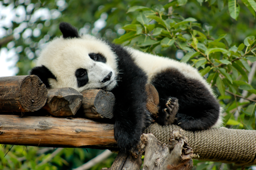

In [5]:
dest = 'china_panda.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

## Red Panda

searching for 'red panda photos'


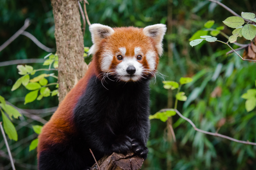

In [6]:
download_url(search_images('red panda photos', max_images=1)[0], 'red_panda.jpg', show_progress=False)
Image.open('red_panda.jpg').to_thumb(256, 256)

## Stuffed Panda

searching for 'stuffed panda photos'


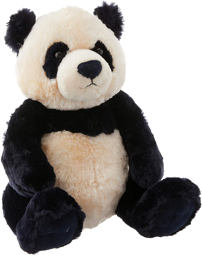

In [7]:
download_url(search_images('stuffed panda photos', max_images=1)[0], 'stuffed_panda.jpg', show_progress=False)
Image.open('stuffed_panda.jpg').to_thumb(256, 256)

# Creating the Dataset

Keywords "in sun" and "in shade" have been defined to get more images in various lightings. This leads to a total of 225 (75x3) downloaded images per class.

In [10]:
searches = 'china panda', 'red panda', 'stuffed panda'
path = Path('assets')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

searching for 'china panda photo'
searching for 'china panda in sun photo'
searching for 'china panda in shade photo'
searching for 'red panda photo'
searching for 'red panda in sun photo'
searching for 'red panda in shade photo'
searching for 'stuffed panda photo'
searching for 'stuffed panda in sun photo'
searching for 'stuffed panda in shade photo'


Removing bad or improperly downloaded images

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

# Augmenting and loading Data

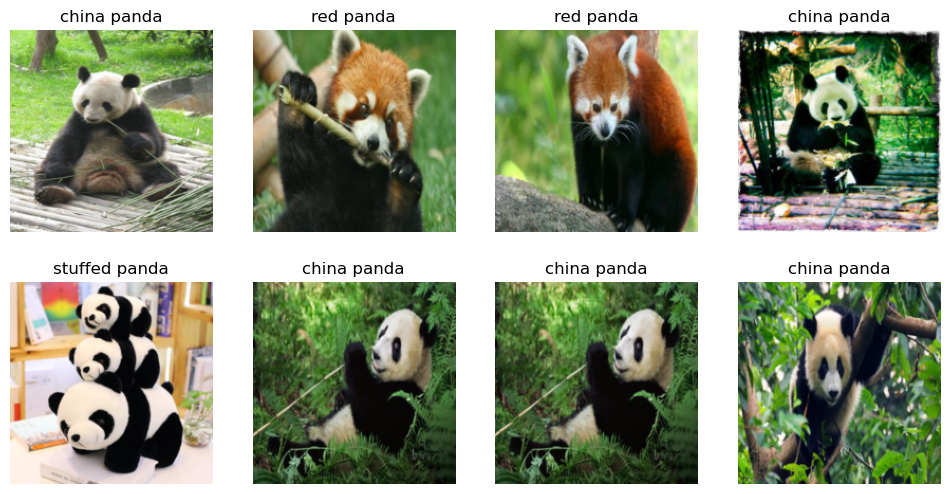

In [13]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

The above is a preview of 8 images of the created dataset.

# Results before Cleaning data

As shown below, Resnet18 has an accuracy of 97.1% (accuracy = (1-error_rate)*100)) and AlexNet has an accuracy of 95.6%.

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.720581,0.265683,0.029412,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.237812,0.539891,0.063725,00:07
1,0.155913,0.207408,0.024510,00:07


In [19]:
learn2 = vision_learner(dls, alexnet, metrics=error_rate)
learn2.fine_tune(2)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.792509,0.229352,0.024510,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.249423,0.252922,0.044118,00:08
1,0.169655,0.282880,0.044118,00:07


Let's see if we can improve the accuracy of AlexNet by cleaning our data.

# Confusion Matrix

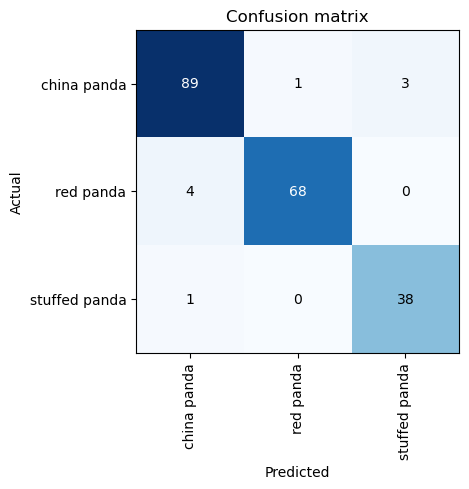

In [20]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

showing the 10 worst predictions by AlexNet

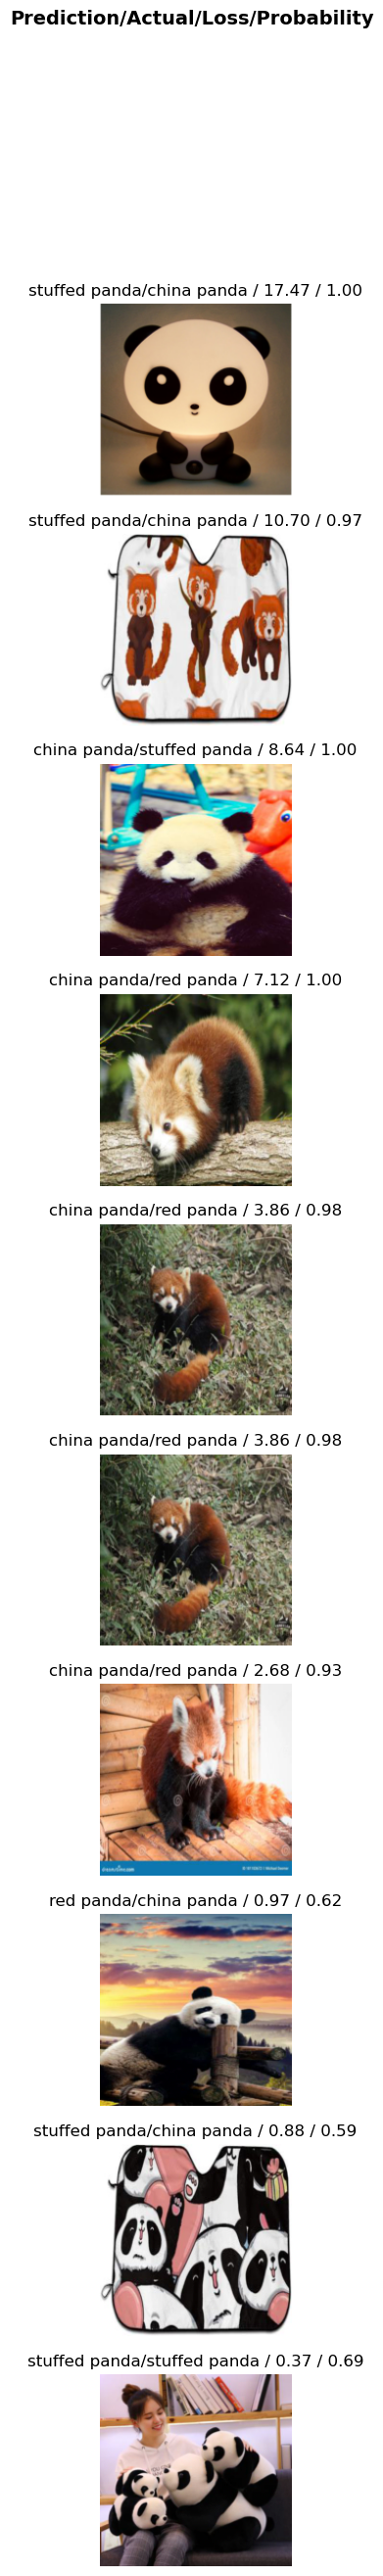

In [24]:
interp.plot_top_losses(10, nrows=10)

# Cleaning the Data

Please rerun the notebook if you cannot see the cleaner widget below

In [25]:
cleaner = ImageClassifierCleaner(learn2)
cleaner

In [32]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Retraining AlexNet

loading the cleaned data and retraining the model

In [36]:
dls2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

In [39]:
learn2 = vision_learner(dls, alexnet, metrics=error_rate)
learn2.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.876794,0.162428,0.029703,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.217029,0.055766,0.014851,00:07


As you can see, the accuracy went up from 95.6% to 98.6% ! This is much better than what we achieved earlier.